In [1]:
import hmftpy as hmf
import numpy as np
import matplotlib.pyplot as plt
from hmftpy.plaquettes.square import plaq4
from hmftpy.plaquettes.triangular import plaq12
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm

# Example 1: Antiferromagnetic J1-J2 XY interaction with an external magnetic field
Here, we construct the Hamiltonian
\begin{equation}
    H = -h \sum_i \sigma_i^z - J_1\sum_{\langle i, j\rangle} \left(
    \sigma_i^x \sigma_j^x + \sigma_i^y \sigma_j^y\right)
    - J_2\sum_{\langle \langle i, j\rangle\rangle} \left(
    \sigma_i^x \sigma_j^x + \sigma_i^y \sigma_j^y
    \right)
\end{equation}
on the square lattice, and compare energies from HMFT and ED with open and periodic boundary conditions (OBC and PBC, respectively) on a 4-site cluster.

In [2]:
basis = spin_basis_1d(4, pauli=0) # pauli=0 fixes the operators as spin-1/2, rather than pauli matrices
h = 1
J1 = -1
J2 = -0.1
interactions = {'local': {'z': -h},
                'nearest': {'xx': -J1, 'yy': -J1},
                'n_nearest': {'xx': -J2, 'yy': -J2}}
Hi = hmf.operators.inner_hamiltonian(plaq4, interactions, basis)
e, v = Hi.eigh()
ei = e[0]
Hp = hmf.operators.periodic_hamiltonian(plaq4, interactions, basis)
e, v = Hp.eigh()
ep = e[0]
e_hmft, v, mf, cvg = hmf.do_hmft(plaq4, interactions, basis)
print('ED energy with OBC: {}'.format(ei))
print('ED energy with PBC: {}'.format(ep))
print('HMFT energy: {}'.format(e_hmft))
print('HMFT converged? {}'.format(cvg))

ED energy with OBC: -2.899999999999997
ED energy with PBC: -5.460388679233946
HMFT energy: -4.160160954671295
HMFT converged? True


# Example 2: $J_1$-$J_2$-$J_3$ Heisenberg on triangular lattice
Now, let's do
\begin{equation}
    H = -h \sum_i \sigma_i^z 
    - J_1\sum_{\langle i, j\rangle}\sigma_i \cdot \sigma_j
    - J_2\sum_{\langle\langle i, j\rangle\rangle}\sigma_i \cdot \sigma_j
    - J_3\sum_{\langle\langle\langle i, j\rangle\rangle\rangle}\sigma_i \cdot \sigma_j
\end{equation}
on the triangular lattice in a 12-site cluster. This time, we will do the ED using sparse matrices (i.e. Lanczos) and reduce our tolerances so everything runs a bit faster.

To make this harder, let's set the nearest and next-next-nearest interaction to antiferromagnetic, but the next-nearest neighbor interaction to ferromagnetic.

In [3]:
basis = spin_basis_1d(12, pauli=0) # pauli=0 fixes the operators as spin-1/2, rather than pauli matrices
h = 1
J1 = -1
J2 = 0.2
J3 = -0.1
bonds = ['xx', 'yy', 'zz']
interactions = {'local': {'z': -h},
                'nearest': {b: -J1 for b in bonds},
                'n_nearest': {b: -J2 for b in bonds},
                'n_n_nearest': {b: -J3 for b in bonds}}
Hi = hmf.operators.inner_hamiltonian(plaq12, interactions, basis, verbose=False)
ei, vi = Hi.eigsh(k=1, which='SA')
Hp = hmf.operators.periodic_hamiltonian(plaq12, interactions, basis, verbose=False)
ep, vp = Hp.eigsh(k=1, which='SA')
e_hmft, v, mf, cvg = hmf.do_hmft(plaq12, interactions, basis, lanczos_tol=10**-12, hmft_tol=10**-9)
print('ED energy with OBC: {}'.format(ei[0]))
print('ED energy with PBC: {}'.format(ep[0]))
print('HMFT energy: {}'.format(e_hmft))
print('HMFT converged? {}'.format(cvg))

ED energy with OBC: -12.975712309322708
ED energy with PBC: -18.740384618136517
HMFT energy: -15.14194014343956
HMFT converged? False


Sometimes, the HMFT doesn't converge. This can be helped by giving it initial mean fields closer to the solution. We can either use mean-fields from other HMFT solutions:

In [4]:
mf_ops = hmf.operators.mf_ops(plaq12, basis) # constructing operators that measure mean-field
mfs_obc = hmf.hmf.get_mfs(vi[:,0], mf_ops)
e_hmft_obc, v, mf, cvg = hmf.do_hmft(plaq12, interactions, basis, mf0=mfs_obc,
                                    lanczos_tol=10**-12, hmft_tol=10**-9)
print('HMFT energy from OBC seed: {}'.format(e_hmft_obc))
print('HMFT converged? {}'.format(cvg))
mfs_pbc = hmf.hmf.get_mfs(vp[:,0], mf_ops)
e_hmft_pbc, v, mf, cvg = hmf.do_hmft(plaq12, interactions, basis, mf0=mfs_pbc,
                                     lanczos_tol=10**-12, hmft_tol=10**-9)
print('HMFT energy from PBC seed: {}'.format(e_hmft_obc))
print('HMFT converged? {}'.format(cvg))

HMFT energy from OBC seed: -12.975712309322681
HMFT converged? True
HMFT energy from PBC seed: -12.975712309322681
HMFT converged? True


That converged, but it converged by setting the mean-fields to zero, giving us the OBC result!

Let's try something else: we'll start with $J_3=0$ and iterate solutions while increasing $J_3$. This is also a good technique to use if you want to see the effect of gradually turning on or changing an interaction, since it keeps the HMFT solution focused on adiabatically connected solutions in cases where there's degeneracy or competing stable solutions with different energies. 

While I'm at it, I'm also going to save the ground state vectors from HMFT to an array so I can use them to calculate observables later on.

In [6]:
J3s = np.linspace(0, -0.1, 20)[::-1]
energies = np.zeros(20)
energies_pbc = np.zeros(20)
energies_obc = np.zeros(20)
cvgs = [False for i in range(20)]
mf0 = None # so we use a random seed for the initial step
vs = np.zeros((20, basis.Ns), dtype=np.complex128) # These in general can be complex!  d
for i, J3 in enumerate(tqdm(J3s)):
    bonds = ['xx', 'yy', 'zz']
    interactions = {'local': {'z': -h},
                    'nearest': {b: -J1 for b in bonds},
                    'n_nearest': {b: -J2 for b in bonds},
                    'n_n_nearest': {b: -J3 for b in bonds}}
    energies[i], v, mf0, cvgs[i] = hmf.do_hmft(plaq12, interactions, basis, mf0=mf0,
                                               lanczos_tol=10**-12, hmft_tol=10**-9,
                                               ops=mf_ops, Hi=Hi) # Reusing operators speads this up
    vs[i,:] = v
    Hi = hmf.operators.inner_hamiltonian(plaq12, interactions, basis, verbose=False)
    e, v = Hi.eigsh(k=1, which='SA')
    energies_obc[i] = e
    Hp = hmf.operators.periodic_hamiltonian(plaq12, interactions, basis, verbose=False)
    e, v = Hp.eigsh(k=1, which='SA')
    energies_pbc[i] = e
print('Final energy: {}'.format(energies[-1]))
print('Converged? {}'.format(cvgs[-1]))


100%|██████████| 20/20 [01:59<00:00,  5.97s/it]

Final energy: -14.441024966095497
Converged? True


That gave us a converged solution with energy lower than the OBC situation. Let's plot these energies as a function of $J_3$, comparing to the OBC and PBC ED results.

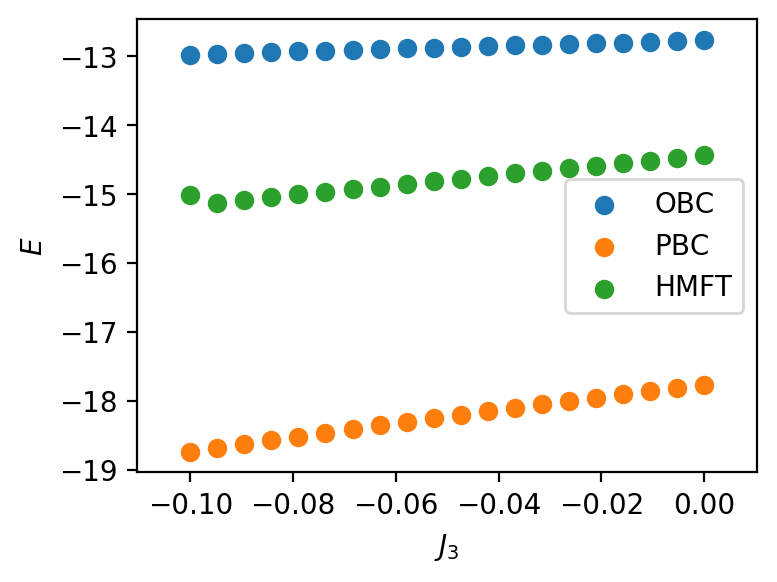

In [7]:
plt.figure(figsize=(4,3), dpi=200)
plt.scatter(J3s, energies_obc, label='OBC')
plt.scatter(J3s, energies_pbc, label='PBC')
plt.scatter(J3s, energies, label='HMFT')
plt.legend()
plt.xlabel(r'$J_3$')
plt.ylabel(r'$E$')
plt.show()

## Observables
In the last calculation, I saved the HMFT ground state at each step. We can use these vectors to calculate expectation values. Let's construct a few operators to measure:
\begin{align}
M_z =& \frac{1}{N}\sum_{i=1}^N \sigma_i^z\\
\chi_{ijk} =& \vec\sigma_i \cdot \left(\vec\sigma_j \times \vec\sigma_k\right)
\end{align}
For the magnetization $M_z$, it seems natural to let $i$ run over all spins in the cluster. For the scalar chirality $\chi_{ijk}$, let's measure for $[i,j,k] = [3,4,6]$, since these form a triangle of nearest-neighbor sites far from the edges of the cluster.

In [10]:
Mz = quantum_operator({'static': [['z', [[1./12, i] for i in range(12)]]]}, basis=basis)
chi = quantum_operator({'static': [['xyz', [[1,3,4,6]]],
                                   ['xzy', [[-1,3,4,6]]],
                                   ['yzx', [[1,3,4,6]]],
                                   ['yxz', [[-1,3,4,6]]],
                                   ['zxy', [[1,3,4,6]]],
                                   ['zyx', [[-1,3,4,6]]]]}, basis=basis)

Hermiticity check passed!
Symmetry checks passed!
Hermiticity check passed!
Symmetry checks passed!


For both operators, let's measure both their expectation value $\langle \psi | \theta | \psi\rangle$ and
the expectation value of the operator squared: $\langle \psi|\theta^2 |\psi\rangle = \langle \psi|\theta \left(\theta|\psi\rangle\right)$.

In [13]:
Mzs = np.zeros(20)
Mz2s = np.zeros(20)
chis = np.zeros(20)
chi2s = np.zeros(20)
for i in range(20):
    v = vs[i,:]
    # expt_value calculates expectation value for one vector
    Mzs[i] = Mz.expt_value(v).real # imaginary part is zero but throws a warning if we keep it
    # matrix_ele calculates matrix element between two vectors, dot is matrix-vector product
    Mz2s[i] = Mz.matrix_ele(v, Mz.dot(v)).real
    chis[i] = chi.expt_value(v).real
    chi2s[i] = chi.matrix_ele(v, chi.dot(v)).real

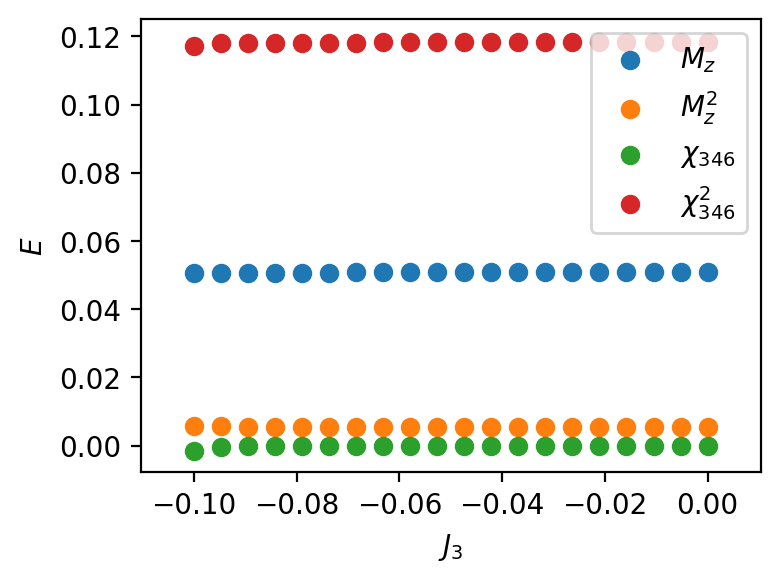

In [15]:
plt.figure(figsize=(4,3), dpi=200)
plt.scatter(J3s, Mzs, label=r'$M_z$')
plt.scatter(J3s, Mz2s, label=r'$M_z^2$')
plt.scatter(J3s, chis, label=r'$\chi_{346}$')
plt.scatter(J3s, chi2s, label=r'$\chi_{346}^2$')
plt.legend()
plt.xlabel(r'$J_3$')
plt.ylabel(r'$E$')
plt.show()

## Plotting spin orientations

While we're drawing pictures, how about we plot spin orientations? Conveniently, I've already measured all components of
$\vec \sigma_i$ to calculte my mean-fields (saved in the variable `mf0`), so no more measurement steps are needed. Now we just need to encode all the geometry of the lattice. 

In [16]:
import matplotlib
cm = matplotlib.cm.magma
norm = matplotlib.colors.Normalize(vmin=-0.5, vmax=0.5)

az = .5*np.sqrt(3) # vertical displacement for equilateral triangles

def draw_tri_lattice(r0, Lx, Ly, color='lightgray'):
    x0, y0 = r0
    x, y = x0, y0
    for i in range(Lx):
        for j in range(Ly):
            xa = x + 1
            ya = y
            xb = x + .5
            yb = y + az
            plt.plot((xb, x, xa, xb), (yb, y, ya, yb), color=color, zorder=0, linewidth=1)
            x = xa
        if i%2 == 1:
            x = x0
            y = y0 + (i+1)*az
        else:
            x = x0 - .5
            y = y0 + (i+1)*az
    
def draw_12_cluster(r0, color='purple', fill=True):
    x0, y0 = r0
    plt.plot((x0, x0-.5, x0, x0+.5, x0+1.5, x0+2, x0+2.5, x0+2, x0+1, x0), 
             (y0, y0+az, y0+2*az, y0+3*az, y0+3*az, y0+2*az, y0+az, y0, y0, y0), 
             color=color, zorder=1, linewidth=1)
    if fill:
        plt.plot((x0, x0+1.5), (y0, y0+3*az),
                 color=color, zorder=1, linewidth=1)
        plt.plot((x0+1, x0+2), (y0, y0+2*az),
                 color=color, zorder=1, linewidth=1)
        plt.plot((x0+1, x0), (y0, y0+2*az),
                 color=color, zorder=1, linewidth=1)
        plt.plot((x0+2, x0+.5), (y0, y0+3*az),
                 color=color, zorder=1, linewidth=1)
        plt.plot((x0-.5, x0+2.5), (y0+az, y0+az),
                 color=color, zorder=1, linewidth=1)
        plt.plot((x0, x0+2), (y0+2*az, y0+2*az),
                 color=color, zorder=1, linewidth=1)
        

xs = np.array([0, 1, 2, 
               -.5, .5, 1.5, 2.5, 
               0, 1, 2,
              .5, 1.5])
ys = np.array([0, 0, 0, az, az, az, az, 2*az, 2*az, 2*az, 3*az, 3*az])

def plot_spins(mf0, r0=(0,0)):
    x0, y0 = r0
    zs = np.real(mf0['z'])
    plt.quiver(xs+x0, ys+y0, mf0['x'], mf0['y'], zorder=10, color=cm(norm(zs)))
    
r0s = [(0,0), (3,2*az), (3,-2*az), (-3,-2*az), (-3,2*az), (0,4*az), (0,-4*az)]


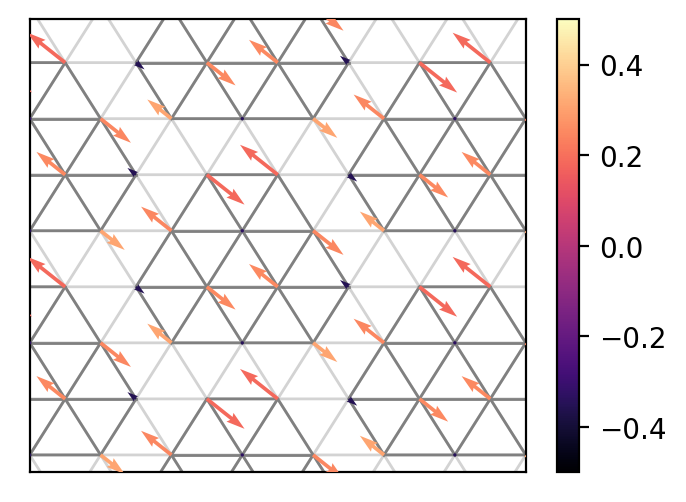

In [17]:
plt.figure(figsize=(4,3), dpi=200)
draw_tri_lattice((-3, -4*az), 10, 10)
for r0 in r0s:
    draw_12_cluster(r0, color='gray')
    plot_spins(mf0, r0)
plt.xlim(-2, 5)
plt.ylim(-2, 5)
plt.xticks([])
plt.yticks([])
sm = matplotlib.cm.ScalarMappable(cmap=cm, norm=norm)
plt.colorbar(sm)